In [0]:
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle

In [0]:
!kaggle competitions download -c msk-redefining-cancer-treatment

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("test_text.zip", 'r')
zip_ref.extractall("./")
zip_ref.close()

In [0]:
zip_ref = zipfile.ZipFile("training_text.zip", 'r')
zip_ref.extractall("./")
zip_ref.close()

In [0]:
zip_ref = zipfile.ZipFile("training_variants.zip", 'r')
zip_ref.extractall("./")
zip_ref.close()

In [0]:
zip_ref = zipfile.ZipFile("test_variants.zip", 'r')
zip_ref.extractall("./")
zip_ref.close()

In [0]:
!pip install mlxtend

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
#from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [0]:
# note the seprator in this file
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [0]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [0]:
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 323.837092 seconds


In [0]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [0]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [0]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [0]:

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    
    A =(((C.T)/(C.sum(axis=1))).T)

    B =(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.4544375275459642
Log loss on Test Data using Random Model 2.4759653223204134
-------------------- Confusion matrix --------------------


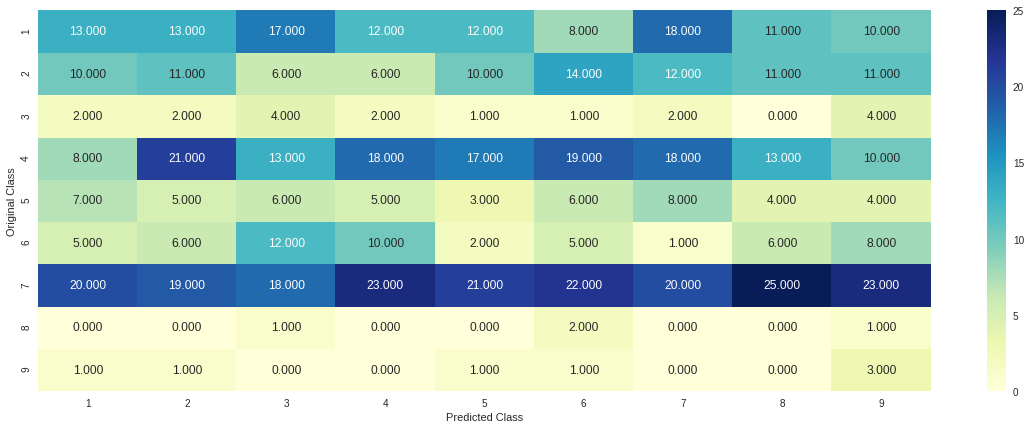

-------------------- Precision matrix (Columm Sum=1) --------------------


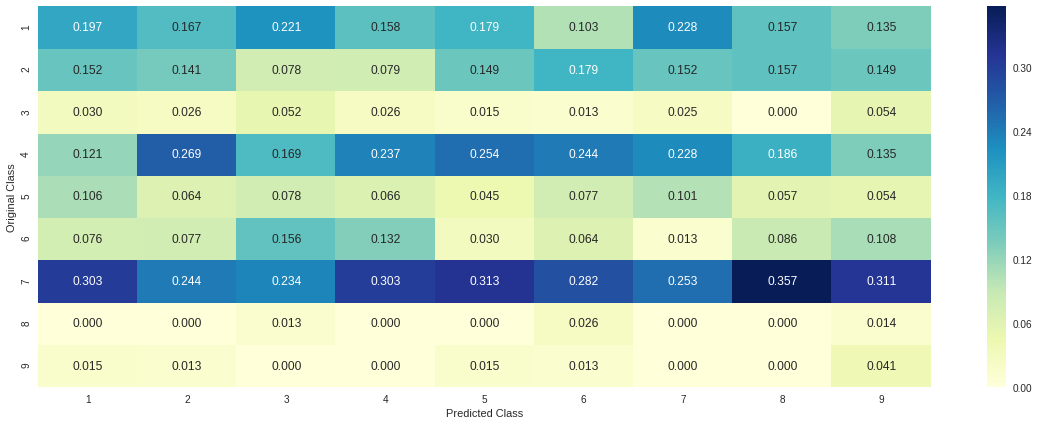

-------------------- Recall matrix (Row sum=1) --------------------


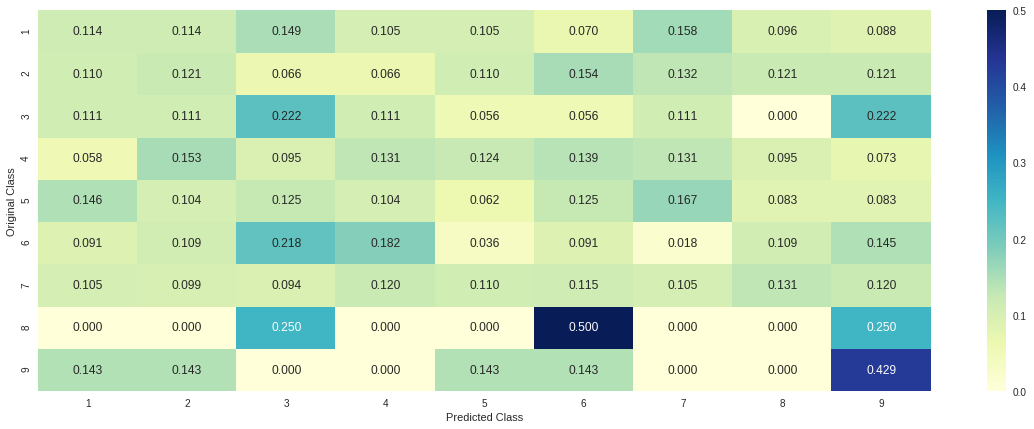

In [0]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [0]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating_Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [0]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [0]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [0]:
train_df['Gene'].head()

2759       BRAF
1829    PPP2R1A
2088       AGO2
2997        KIT
2996        KIT
Name: Gene, dtype: object

In [0]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [0]:
vectorizer = TfidfVectorizer(min_df=3,norm="l2",tokenizer = lambda x: x.split(), smooth_idf=True,decode_error='replace')
x_train_tfidf = vectorizer.fit_transform(train_df['TEXT'].values.astype('U'))
x_test_tfidf = vectorizer.transform(test_df['TEXT'].values.astype('U'))
x_test_cv =vectorizer.transform(cv_df['TEXT'].values.astype('U'))

In [0]:
x_train_tfidf.shape

(2124, 53163)

In [0]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [0]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [0]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_tfidf = hstack((train_gene_var_onehotCoding, x_train_tfidf)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_tfidf= hstack((test_gene_var_onehotCoding, x_test_tfidf)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_tfidf = hstack((cv_gene_var_onehotCoding, x_test_cv)).tocsr()
cv_y = np.array(list(cv_df['Class']))

<h2>Naive Bayes</h2>

for alpha = 1e-05
Log Loss : 1.1372021781611794
for alpha = 0.0001
Log Loss : 1.1357554680933504
for alpha = 0.001
Log Loss : 1.1266745649081906
for alpha = 0.1
Log Loss : 1.1414336827949982
for alpha = 1
Log Loss : 1.1836636161392622
for alpha = 10
Log Loss : 1.2063641726212986
for alpha = 100
Log Loss : 1.2609804640124913
for alpha = 1000
Log Loss : 1.273631050387002


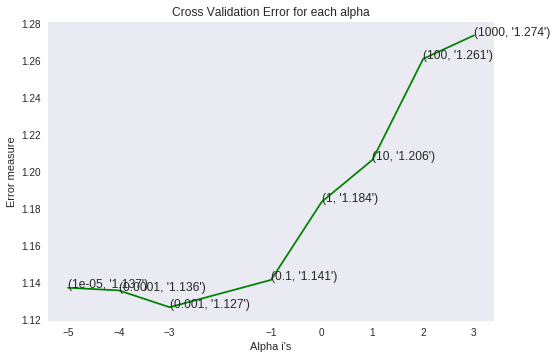

For values of best alpha =  0.001 The train log loss is: 0.6659140457965383
For values of best alpha =  0.001 The cross validation log loss is: 1.1266745649081906
For values of best alpha =  0.001 The test log loss is: 1.1752847754167381


In [0]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.1266745649081906
Number of missclassified point : 0.33270676691729323
-------------------- Confusion matrix --------------------


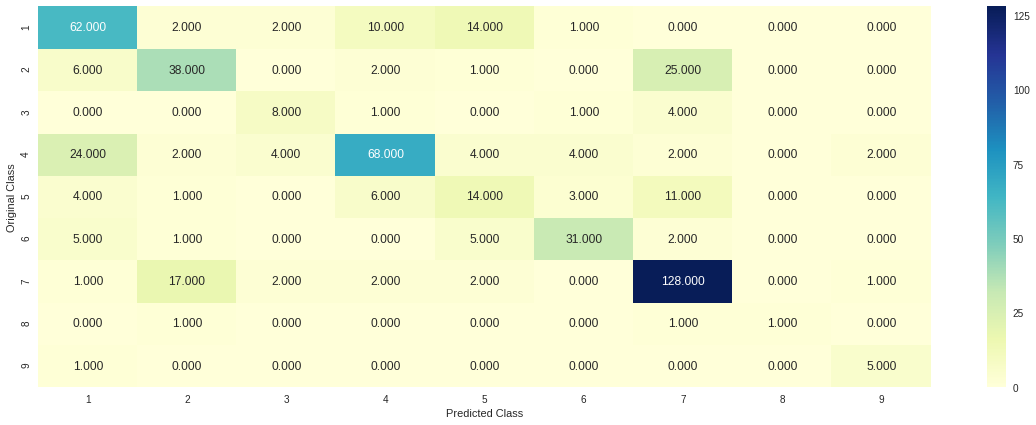

-------------------- Precision matrix (Columm Sum=1) --------------------


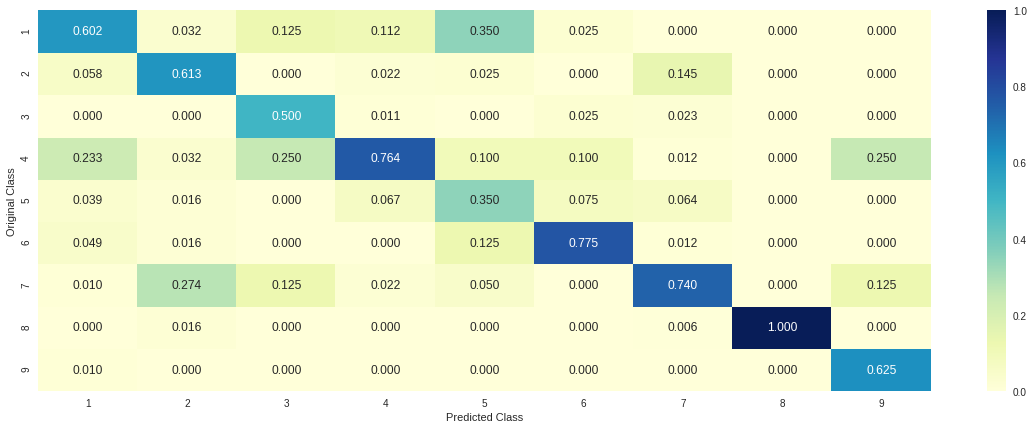

-------------------- Recall matrix (Row sum=1) --------------------


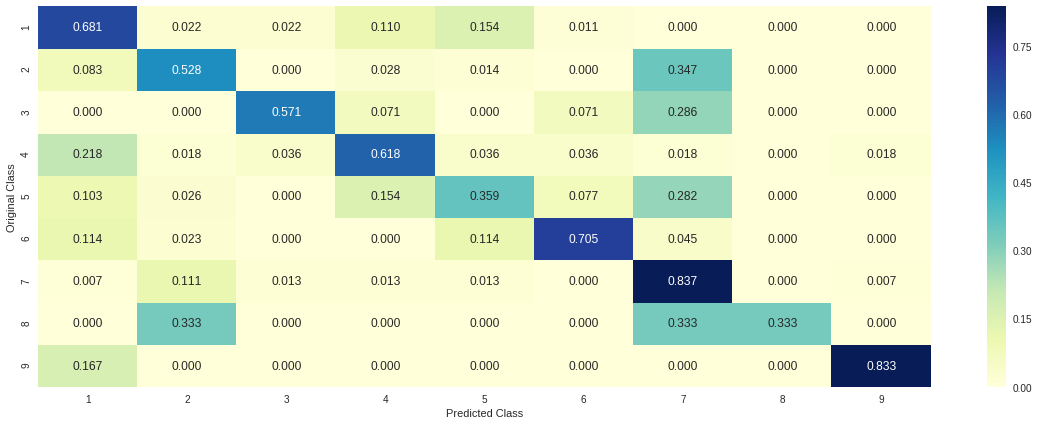

In [0]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

<h2> K Nearest Neighbour Classification</h2>

for alpha = 5
Log Loss : 1.0586079540789077
for alpha = 11
Log Loss : 1.102688680559598
for alpha = 15
Log Loss : 1.1449177597937426
for alpha = 21
Log Loss : 1.1984745470925184
for alpha = 31
Log Loss : 1.2231004122685076
for alpha = 41
Log Loss : 1.2593350298562829
for alpha = 51
Log Loss : 1.284254473193485
for alpha = 99
Log Loss : 1.3522936362424218


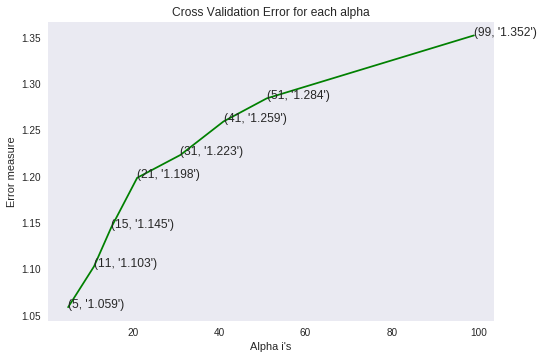

For values of best alpha =  5 The train log loss is: 0.9002217393343086
For values of best alpha =  5 The cross validation log loss is: 1.0586079540789077
For values of best alpha =  5 The test log loss is: 1.1420660387886843


In [0]:


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.0586079540789077
Number of mis-classified points : 0.36466165413533835
-------------------- Confusion matrix --------------------


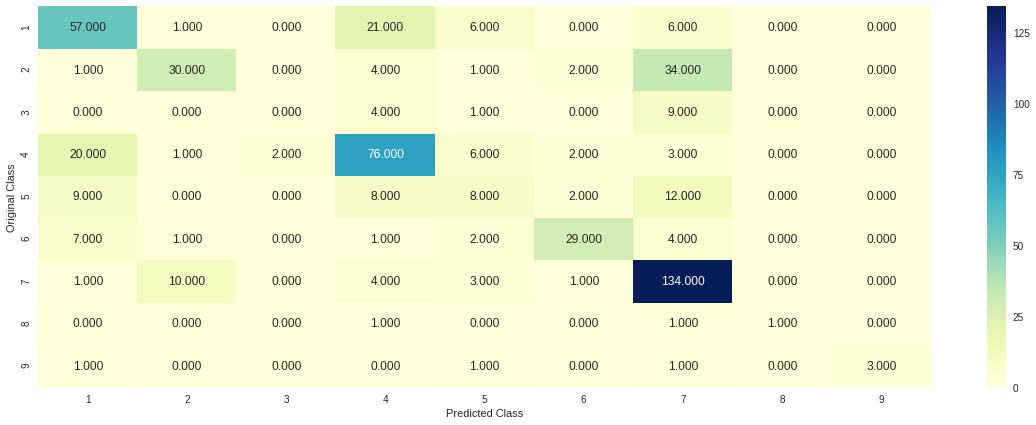

-------------------- Precision matrix (Columm Sum=1) --------------------


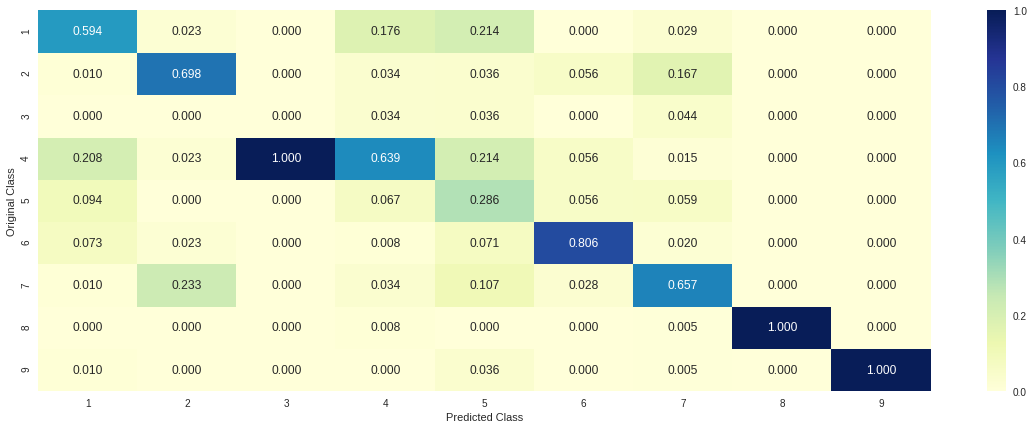

-------------------- Recall matrix (Row sum=1) --------------------


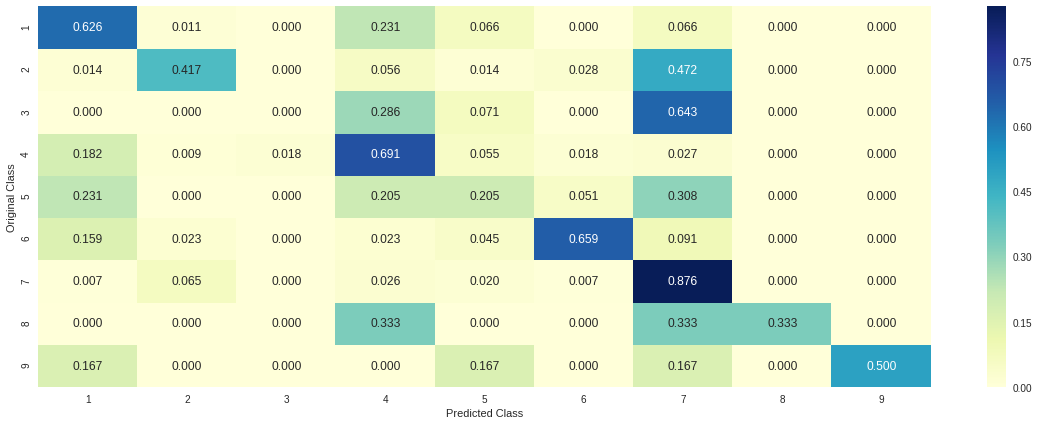

In [0]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, cv_x_tfidf, cv_y, clf)

<h2>Logistic Regression</h2>

for alpha = 1e-06
Log Loss : 1.1620153137291538
for alpha = 1e-05
Log Loss : 1.0449245486483256
for alpha = 0.0001
Log Loss : 0.9281061869676464
for alpha = 0.001
Log Loss : 0.9846289849855896
for alpha = 0.01
Log Loss : 1.1773886536925282
for alpha = 0.1
Log Loss : 1.4279479727539681
for alpha = 1
Log Loss : 1.530378141775562
for alpha = 10
Log Loss : 1.5441491972798267
for alpha = 100
Log Loss : 1.5457660838988163


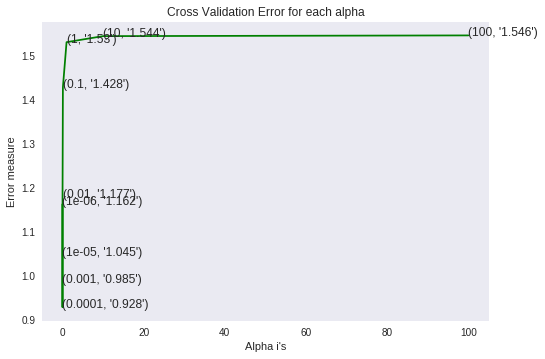

For values of best alpha =  0.0001 The train log loss is: 0.428297539452384
For values of best alpha =  0.0001 The cross validation log loss is: 0.9281061869676464
For values of best alpha =  0.0001 The test log loss is: 0.9945964154840102


In [0]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.9281061869676464
Number of mis-classified points : 0.31390977443609025
-------------------- Confusion matrix --------------------


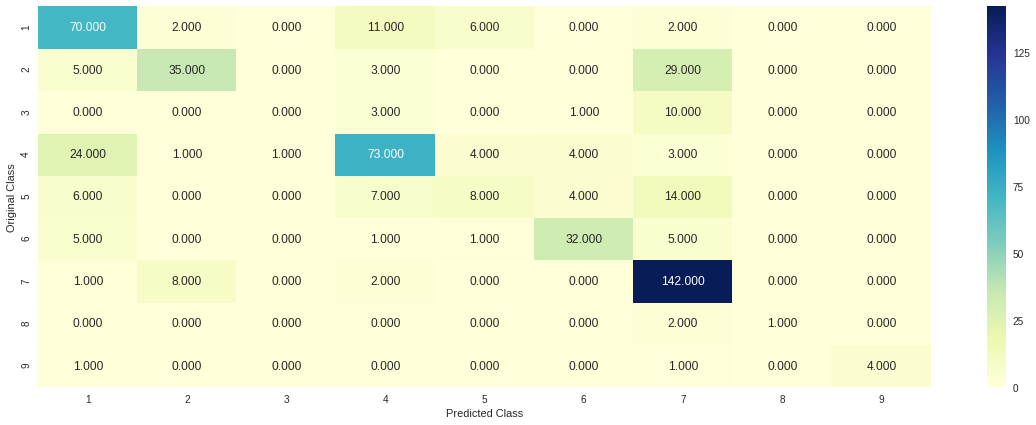

-------------------- Precision matrix (Columm Sum=1) --------------------


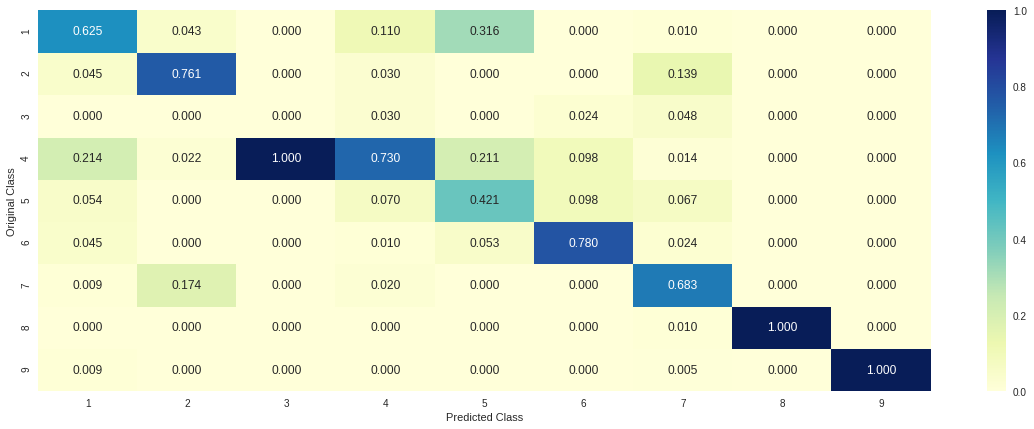

-------------------- Recall matrix (Row sum=1) --------------------


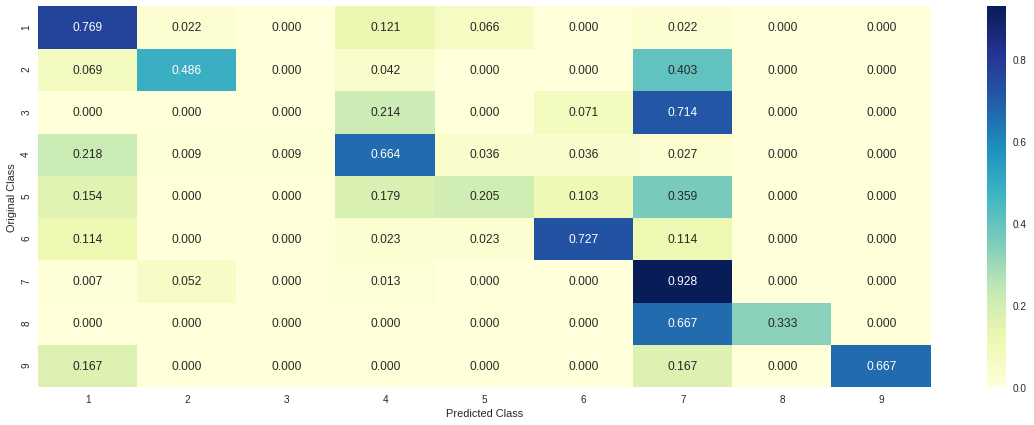

In [0]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h2> Linear Support Vector Machines</h2>

for C = 1e-05
Log Loss : 1.1159092020742334
for C = 0.0001
Log Loss : 1.055709175404768
for C = 0.001
Log Loss : 1.035429234638376
for C = 0.01
Log Loss : 1.1958115807196554
for C = 0.1
Log Loss : 1.4608615215824914
for C = 1
Log Loss : 1.5461866799821675
for C = 10
Log Loss : 1.546188351878274
for C = 100
Log Loss : 1.5461866836970157


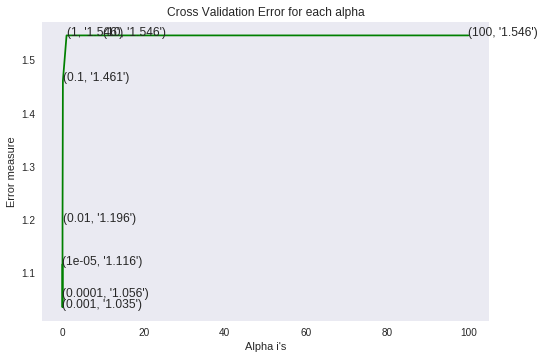

For values of best alpha =  0.001 The train log loss is: 0.5675260123008236
For values of best alpha =  0.001 The cross validation log loss is: 1.035429234638376
For values of best alpha =  0.001 The test log loss is: 1.1017248527830692


In [0]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.035429234638376
Number of mis-classified points : 0.3308270676691729
-------------------- Confusion matrix --------------------


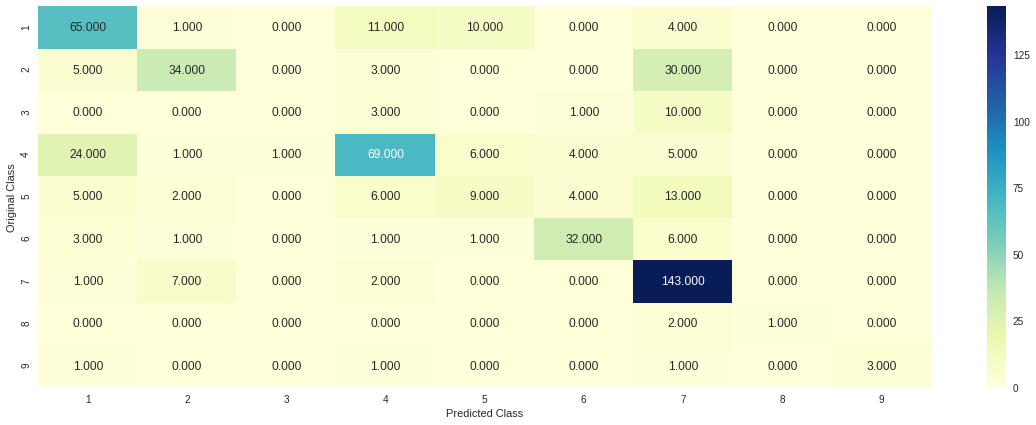

-------------------- Precision matrix (Columm Sum=1) --------------------


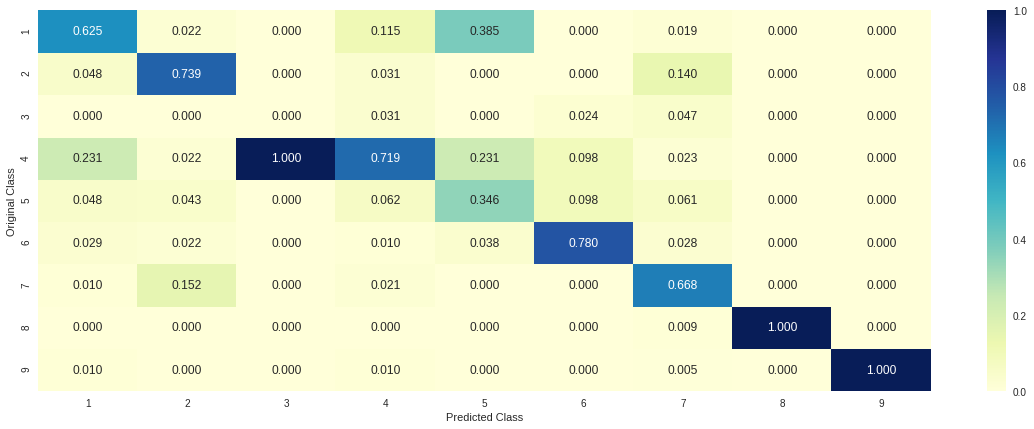

-------------------- Recall matrix (Row sum=1) --------------------


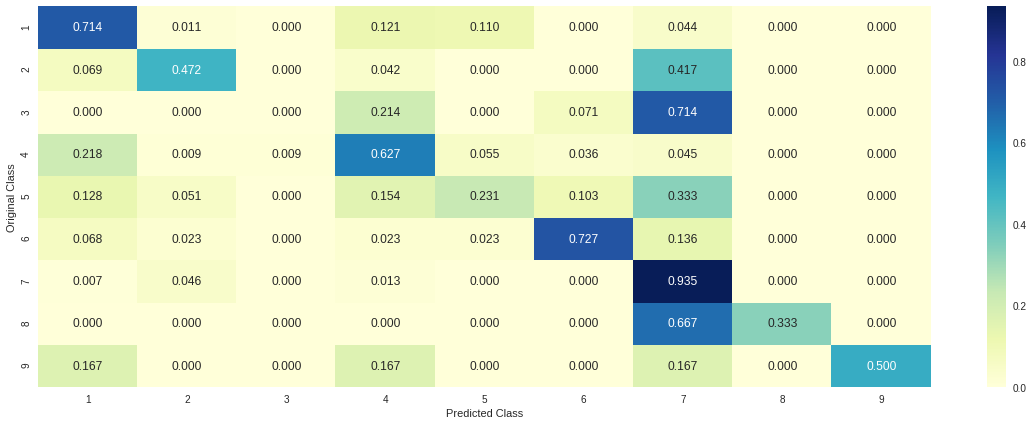

In [0]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h1> RandomForestClassifier</h1>

In [0]:

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
        
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.156189936134909
for n_estimators = 100 and max depth =  10
Log Loss : 1.0680114212147003
for n_estimators = 200 and max depth =  5
Log Loss : 1.1517668040466842
for n_estimators = 200 and max depth =  10
Log Loss : 1.0576389914942768
for n_estimators = 500 and max depth =  5
Log Loss : 1.143453977248742
for n_estimators = 500 and max depth =  10
Log Loss : 1.053199266344046
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1381480561973099
for n_estimators = 1000 and max depth =  10
Log Loss : 1.051155774590468
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1359344862623857
for n_estimators = 2000 and max depth =  10
Log Loss : 1.0496496626389358
For values of best estimator =  2000 The train log loss is: 0.6801863303091096
For values of best estimator =  2000 The cross validation log loss is: 1.0496496626389358
For values of best estimator =  2000 The test log loss is: 1.0939609577844478


Log loss : 1.0496496626389358
Number of mis-classified points : 0.34774436090225563
-------------------- Confusion matrix --------------------


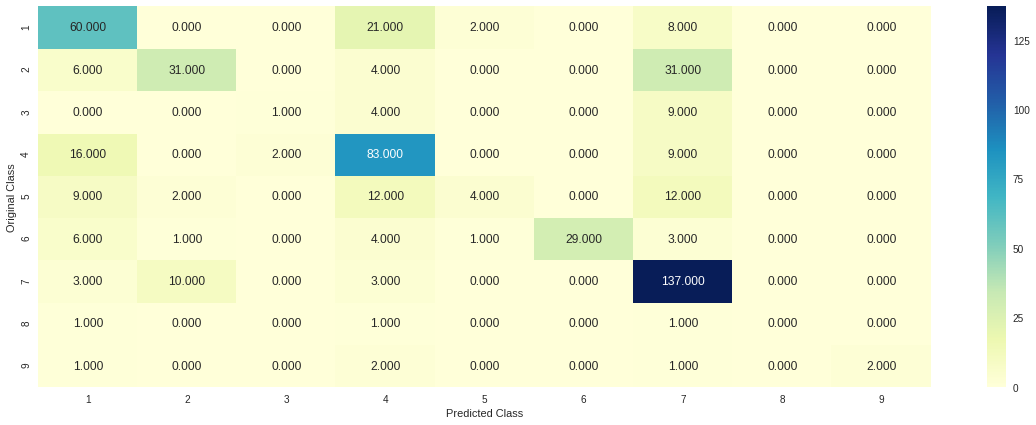

-------------------- Precision matrix (Columm Sum=1) --------------------


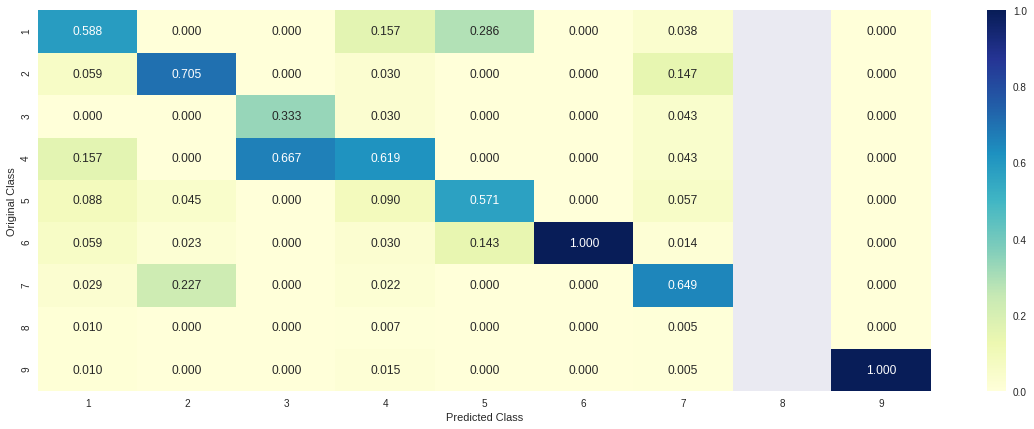

-------------------- Recall matrix (Row sum=1) --------------------


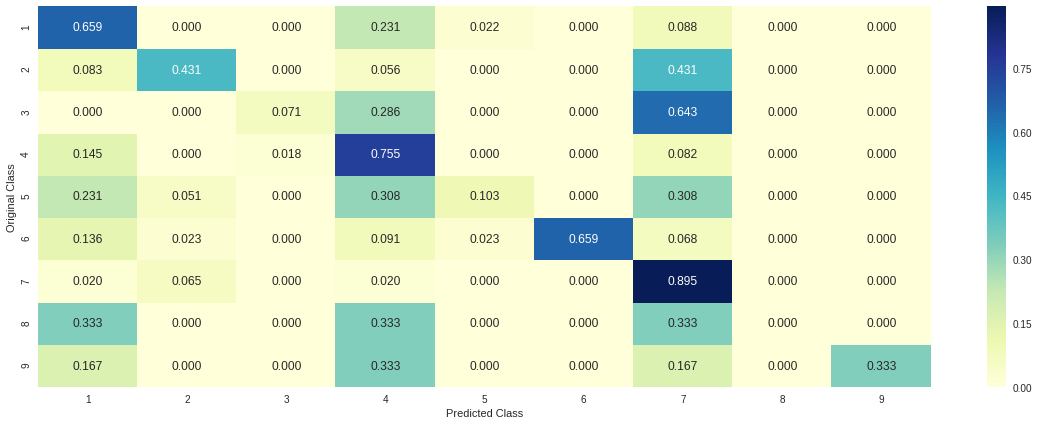

In [0]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h1>StackingClassifier</h1>

In [0]:
clf1 = SGDClassifier(alpha=0.0001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_tfidf, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_tfidf, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_tfidf, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

clf4 = KNeighborsClassifier(n_neighbors=5)
clf4.fit(train_x_tfidf, train_y)
sig_clf4 = CalibratedClassifierCV(clf, method="sigmoid")

sig_clf1.fit(train_x_tfidf, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_tfidf))))
sig_clf2.fit(train_x_tfidf, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_tfidf))))
sig_clf3.fit(train_x_tfidf, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_tfidf))))
sig_clf4.fit(train_x_tfidf, train_y)
print("KNN : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf4.predict_proba(cv_x_tfidf))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3,sig_clf4], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_tfidf, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_tfidf))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_tfidf))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 0.93
Support vector machines : Log Loss: 1.05
Naive Bayes : Log Loss: 1.13
KNN : Log Loss: 1.05
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.170
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.970
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.345
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 0.981
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.078
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.420


Log loss (train) on the stacking classifier : 0.4113088982309288
Log loss (CV) on the stacking classifier : 1.0126743543204015
Log loss (test) on the stacking classifier : 1.0803513307965311
Number of missclassified point : 0.3383458646616541
-------------------- Confusion matrix --------------------


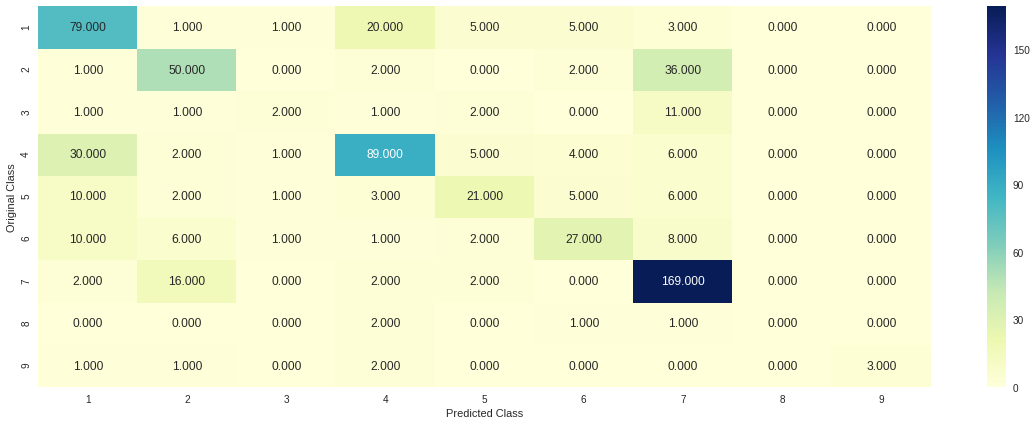

-------------------- Precision matrix (Columm Sum=1) --------------------


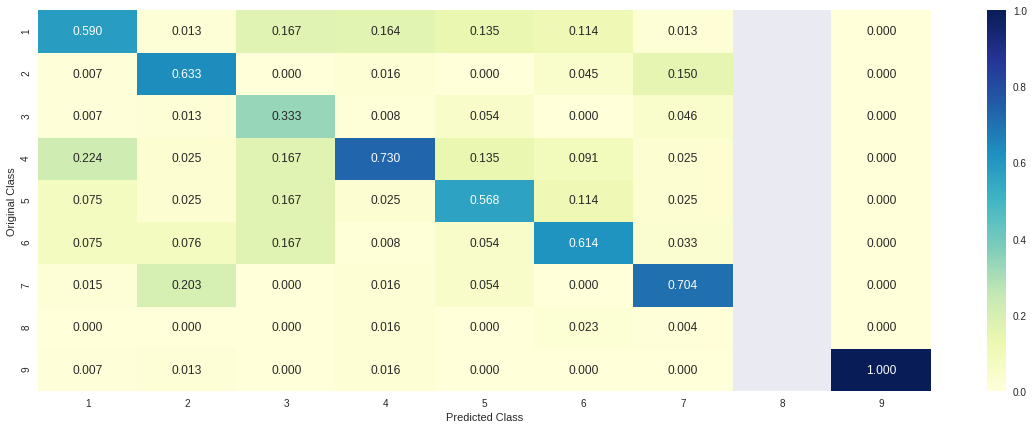

-------------------- Recall matrix (Row sum=1) --------------------


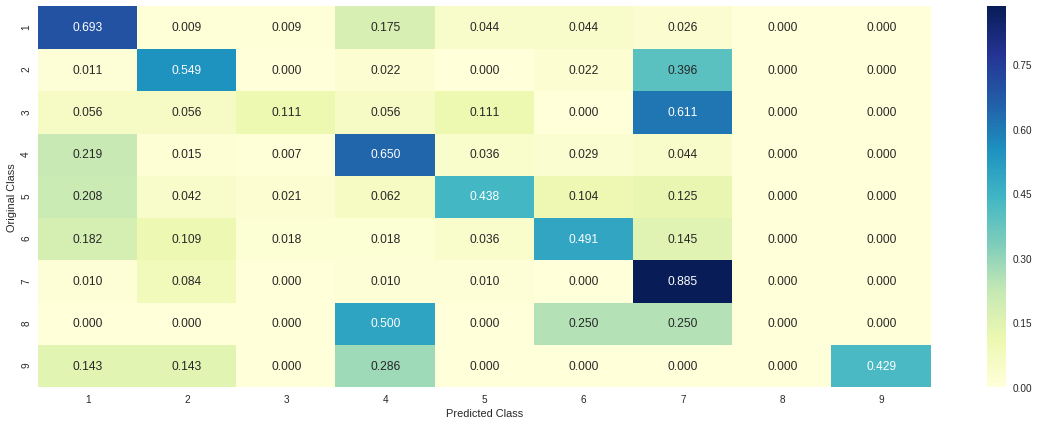

In [0]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_tfidf))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_tfidf))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_tfidf))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_tfidf)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_tfidf))

**Majority VotingClassifier**

Log loss (train) on the VotingClassifier : 0.5632408138499149
Log loss (CV) on the VotingClassifier : 0.9913366791328627
Log loss (test) on the VotingClassifier : 1.0381328562106995
Number of missclassified point : 0.32781954887218046
-------------------- Confusion matrix --------------------


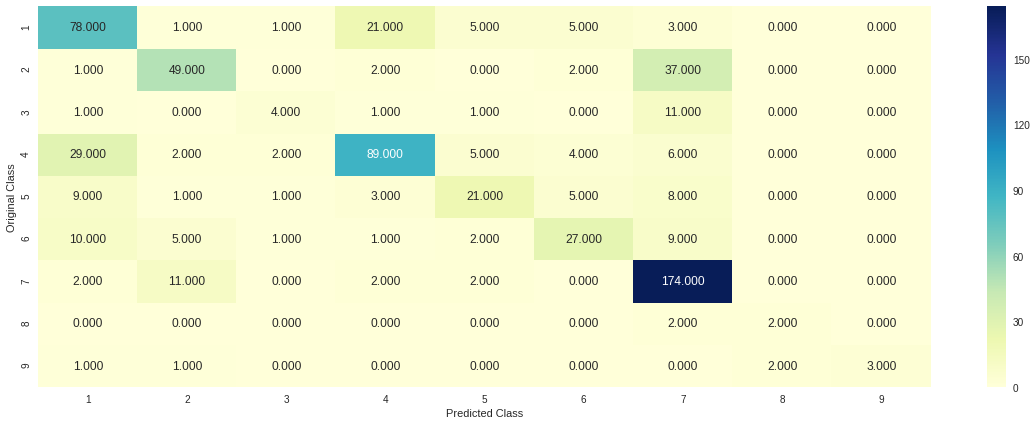

-------------------- Precision matrix (Columm Sum=1) --------------------


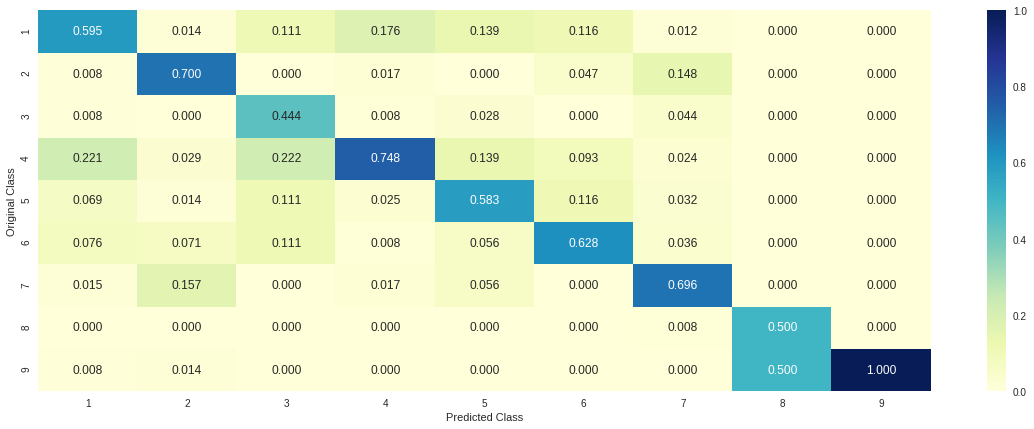

-------------------- Recall matrix (Row sum=1) --------------------


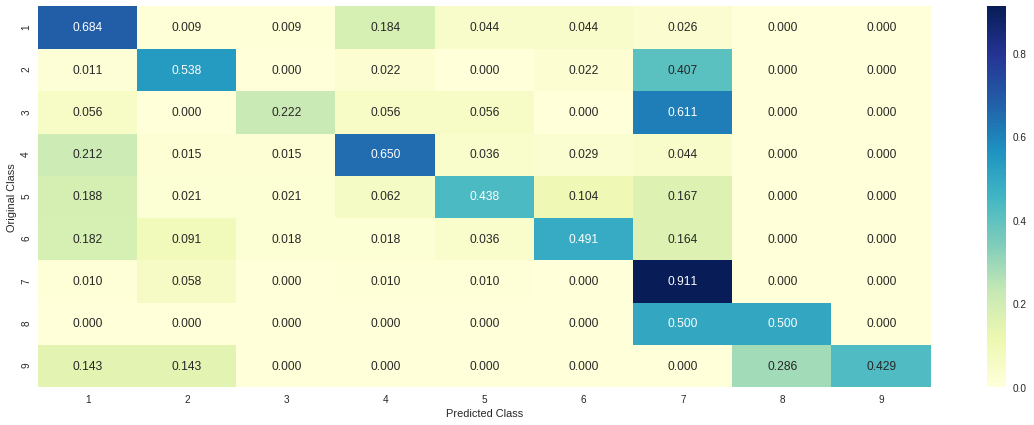

In [0]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3),('knn',sig_clf4)], voting='soft')
vclf.fit(train_x_tfidf, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_tfidf)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_tfidf)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_tfidf)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_tfidf)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_tfidf))

#TFIDF WITH  1000 FEAT

In [0]:
vectorizer = TfidfVectorizer(min_df=3,norm="l2",max_features=1000,tokenizer = lambda x: x.split(), smooth_idf=True,decode_error='replace')
x_train_tfidf_mini = vectorizer.fit_transform(train_df['TEXT'].values.astype('U'))
x_test_tfidf_mini = vectorizer.transform(test_df['TEXT'].values.astype('U'))
x_test_cv_mini =vectorizer.transform(cv_df['TEXT'].values.astype('U'))

In [0]:
x_train_tfidf_mini.shape

(2124, 1000)

In [0]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_tfidf = hstack((train_gene_var_onehotCoding, x_train_tfidf_mini)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_tfidf= hstack((test_gene_var_onehotCoding, x_test_tfidf_mini)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_tfidf = hstack((cv_gene_var_onehotCoding, x_test_cv_mini)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [0]:
train_x_tfidf.shape

(2124, 3189)

for alpha = 1e-05
Log Loss : 1.1730786854192616
for alpha = 0.0001
Log Loss : 1.1728775145050745
for alpha = 0.001
Log Loss : 1.1721374048882365
for alpha = 0.1
Log Loss : 1.1596414003928837
for alpha = 1
Log Loss : 1.1661925010359318
for alpha = 10
Log Loss : 1.2368979495102628
for alpha = 100
Log Loss : 1.2974651464127225
for alpha = 1000
Log Loss : 1.3106311458696678


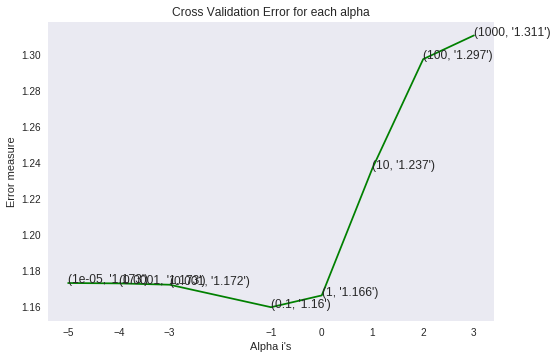

For values of best alpha =  0.1 The train log loss is: 0.6852256538451788
For values of best alpha =  0.1 The cross validation log loss is: 1.1596414003928837
For values of best alpha =  0.1 The test log loss is: 1.201499253127227


In [0]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)


predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [0]:

print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x_tfidf)))
print("Number of mis-classified points :", np.count_nonzero((sig_clf.predict(test_x_tfidf)- test_y))/test_y.shape[0])

Log loss : 1.201499253127227
Number of mis-classified points : 0.3954887218045113


for alpha = 5
Log Loss : 1.0476978416824765
for alpha = 11
Log Loss : 1.1066241149810085
for alpha = 15
Log Loss : 1.1417464659610714
for alpha = 21
Log Loss : 1.1897334604979966
for alpha = 31
Log Loss : 1.2234605265602116
for alpha = 41
Log Loss : 1.2588727662155323
for alpha = 51
Log Loss : 1.2940813795749397
for alpha = 99
Log Loss : 1.3306525623591987


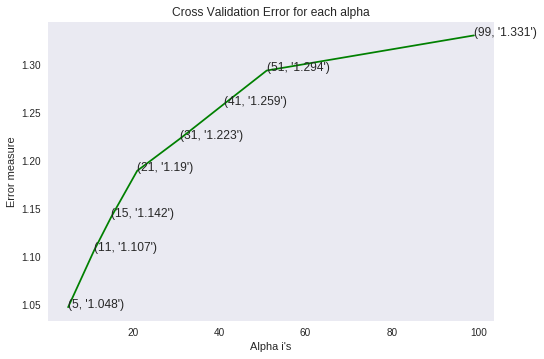

For values of best alpha =  5 The train log loss is: 0.8856996047924309
For values of best alpha =  5 The cross validation log loss is: 1.0476978416824765
For values of best alpha =  5 The test log loss is: 1.1057094487440728


In [0]:


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [0]:
print("Number of mis-classified points :", np.count_nonzero((sig_clf.predict(test_x_tfidf)- test_y))/test_y.shape[0])

Number of mis-classified points : 0.37593984962406013


for alpha = 1e-06
Log Loss : 1.1368008681281119
for alpha = 1e-05
Log Loss : 1.0584231809978661
for alpha = 0.0001
Log Loss : 0.9726146566847341
for alpha = 0.001
Log Loss : 1.0192636368864496
for alpha = 0.01
Log Loss : 1.225137370197835
for alpha = 0.1
Log Loss : 1.5052332267232515
for alpha = 1
Log Loss : 1.6141317025878998
for alpha = 10
Log Loss : 1.6280471258375797
for alpha = 100
Log Loss : 1.629617055402086


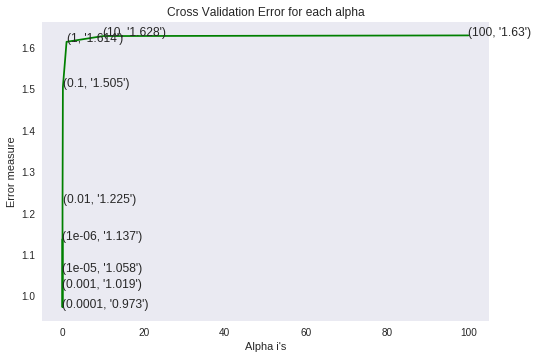

For values of best alpha =  0.0001 The train log loss is: 0.4778875050451089
For values of best alpha =  0.0001 The cross validation log loss is: 0.9726146566847341
For values of best alpha =  0.0001 The test log loss is: 1.0307520273410264


In [0]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [0]:

print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x_tfidf)))
print("Number of mis-classified points :", np.count_nonzero((sig_clf.predict(test_x_tfidf)- test_y))/test_y.shape[0])

Log loss : 1.0307520273410264
Number of mis-classified points : 0.3804511278195489


for C = 1e-05
Log Loss : 1.1083107973678852
for C = 0.0001
Log Loss : 1.079427653010871
for C = 0.001
Log Loss : 1.0828199723064074
for C = 0.01
Log Loss : 1.2604018581259961
for C = 0.1
Log Loss : 1.5280354155648292
for C = 1
Log Loss : 1.629975572173467
for C = 10
Log Loss : 1.629975542808619
for C = 100
Log Loss : 1.6299741038716353


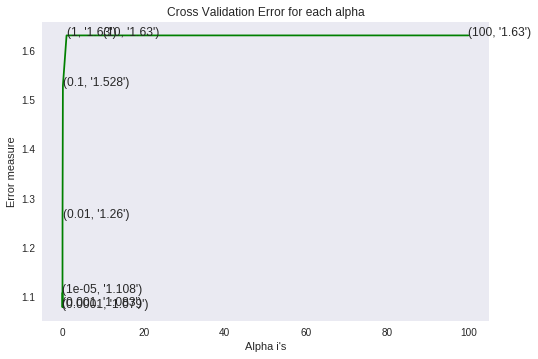

For values of best alpha =  0.0001 The train log loss is: 0.5445149569513164
For values of best alpha =  0.0001 The cross validation log loss is: 1.079427653010871
For values of best alpha =  0.0001 The test log loss is: 1.1207674573783144


In [0]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [0]:

print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x_tfidf)))
print("Number of mis-classified points :", np.count_nonzero((sig_clf.predict(test_x_tfidf)- test_y))/test_y.shape[0])

Log loss : 1.1207674573783144
Number of mis-classified points : 0.3879699248120301


In [0]:

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
        
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.1022093442391174
for n_estimators = 100 and max depth =  10
Log Loss : 1.0548756871933989
for n_estimators = 200 and max depth =  5
Log Loss : 1.0832343671211568
for n_estimators = 200 and max depth =  10
Log Loss : 1.0508296784797584
for n_estimators = 500 and max depth =  5
Log Loss : 1.0786708705618353
for n_estimators = 500 and max depth =  10
Log Loss : 1.0433164119011218
for n_estimators = 1000 and max depth =  5
Log Loss : 1.0736821038213842
for n_estimators = 1000 and max depth =  10
Log Loss : 1.0410066307681696
for n_estimators = 2000 and max depth =  5
Log Loss : 1.071280065897944
for n_estimators = 2000 and max depth =  10
Log Loss : 1.040338062990306
For values of best estimator =  2000 The train log loss is: 0.5706997877246374
For values of best estimator =  2000 The cross validation log loss is: 1.040338062990306
For values of best estimator =  2000 The test log loss is: 1.0688083085258875


In [0]:

print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x_tfidf)))
print("Number of mis-classified points :", np.count_nonzero((sig_clf.predict(test_x_tfidf)- test_y))/test_y.shape[0])

Log loss : 1.0688083085258875
Number of mis-classified points : 0.3458646616541353


Log loss : 1.0496496626389358
Number of mis-classified points : 0.34774436090225563
-------------------- Confusion matrix --------------------


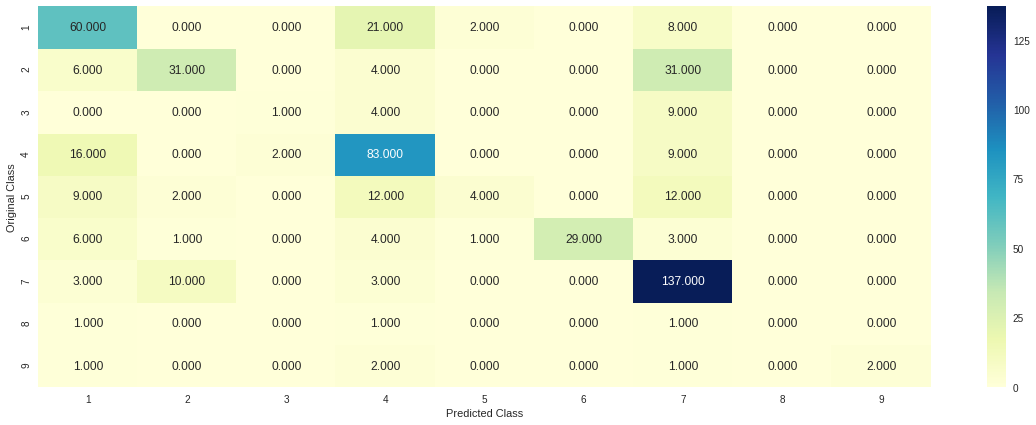

-------------------- Precision matrix (Columm Sum=1) --------------------


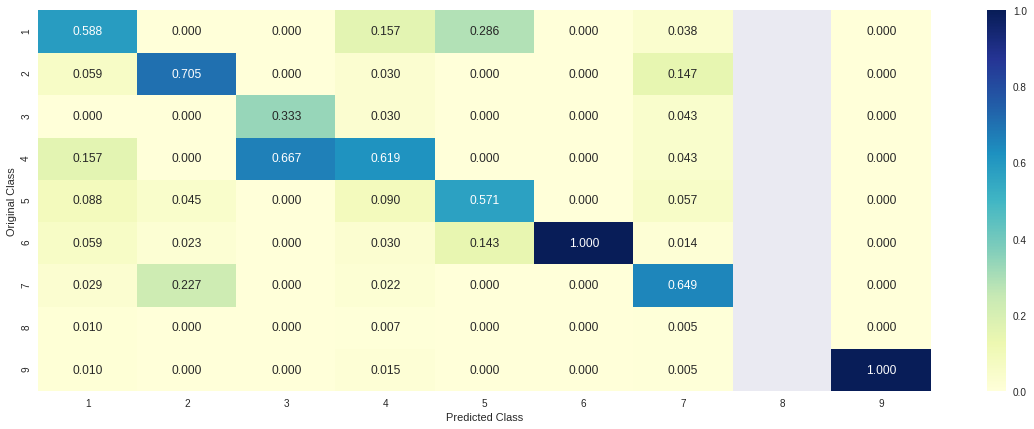

-------------------- Recall matrix (Row sum=1) --------------------


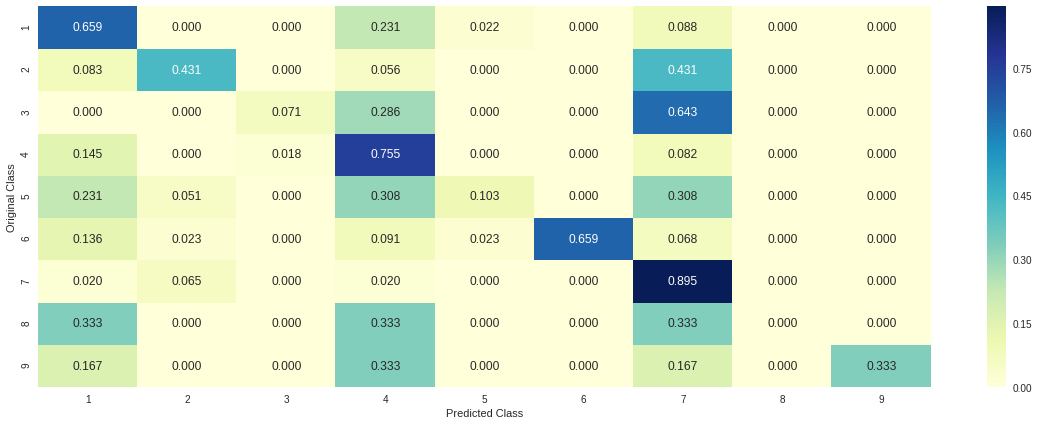

In [0]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h1>TFIDF_ With ngrams</h1>

In [0]:
vectorizer = TfidfVectorizer(min_df=3,norm="l2",ngram_range=(1,3),tokenizer = lambda x: x.split(), smooth_idf=True,decode_error='replace')
x_train_tfidf_ngrams = vectorizer.fit_transform(train_df['TEXT'].values.astype('U'))
x_test_tfidf_ngrams = vectorizer.transform(test_df['TEXT'].values.astype('U'))
x_test_cv_ngrams =vectorizer.transform(cv_df['TEXT'].values.astype('U'))

In [0]:
x_train_tfidf_ngrams.shape

(2124, 1925663)

In [0]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_tfidf = hstack((train_gene_var_onehotCoding, x_train_tfidf_ngrams)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_tfidf= hstack((test_gene_var_onehotCoding, x_test_tfidf_ngrams)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_tfidf = hstack((cv_gene_var_onehotCoding, x_test_cv_ngrams)).tocsr()
cv_y = np.array(list(cv_df['Class']))

for alpha = 1e-06
Log Loss : 1.1739917206813903
for alpha = 1e-05
Log Loss : 1.0674169479880584
for alpha = 0.0001
Log Loss : 0.9210842005806733
for alpha = 0.001
Log Loss : 0.9716068299973554
for alpha = 0.01
Log Loss : 1.1523308774877652
for alpha = 0.1
Log Loss : 1.374805556208743
for alpha = 1
Log Loss : 1.4570664677832408
for alpha = 10
Log Loss : 1.4697966331981764
for alpha = 100
Log Loss : 1.4713496763837235


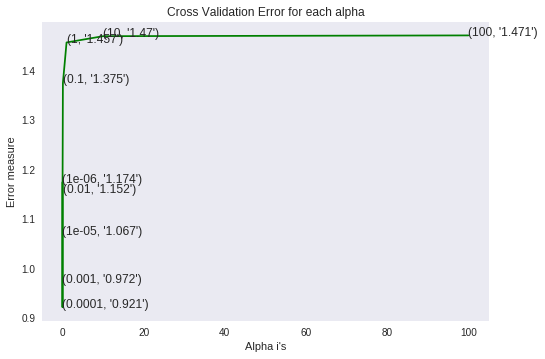

For values of best alpha =  0.0001 The train log loss is: 0.41654266077331503
For values of best alpha =  0.0001 The cross validation log loss is: 0.9210842005806733
For values of best alpha =  0.0001 The test log loss is: 0.988311195134016


In [0]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.9281061869676464
Number of mis-classified points : 0.31390977443609025
-------------------- Confusion matrix --------------------


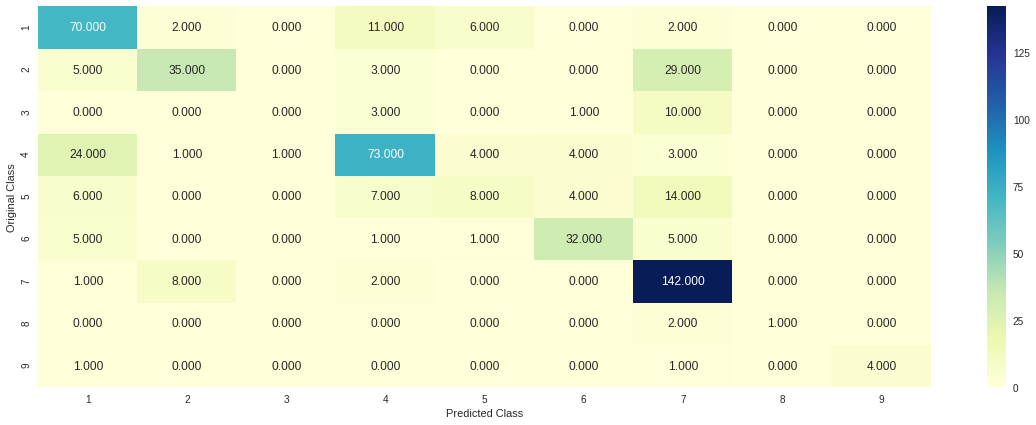

-------------------- Precision matrix (Columm Sum=1) --------------------


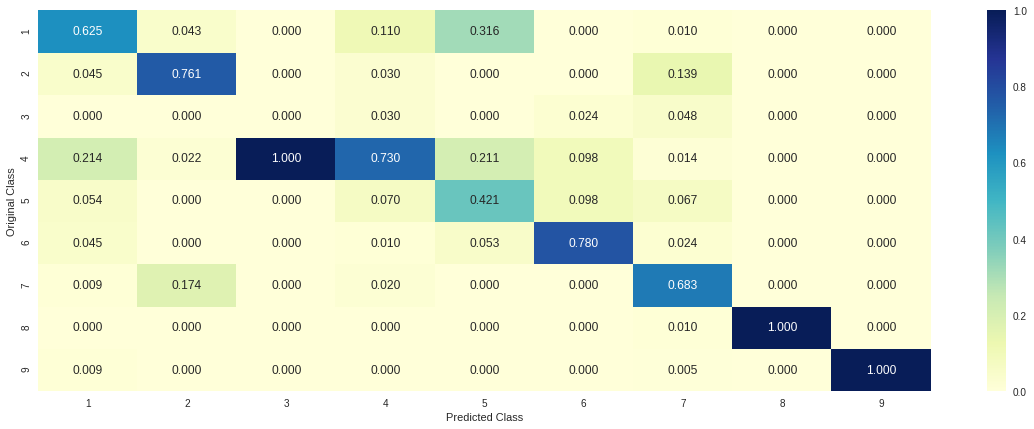

-------------------- Recall matrix (Row sum=1) --------------------


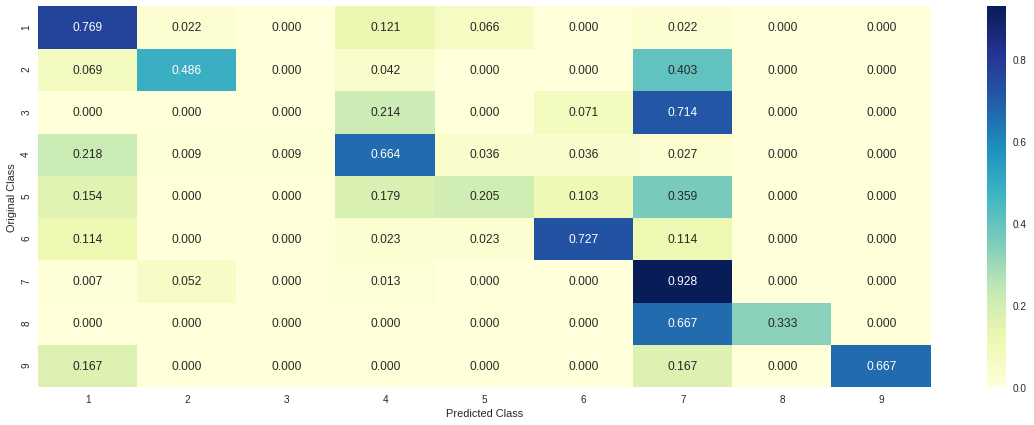

In [0]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h1> feature engineering  to reduce the CV and test log-loss to a value less than 1.0</h1>

In [0]:
len_words=[]
for i in range(len(result['TEXT'])):
    l=len(result['TEXT'][i].split())
    len_words.append(l)

    
    

In [0]:
result['len_words']=len_words

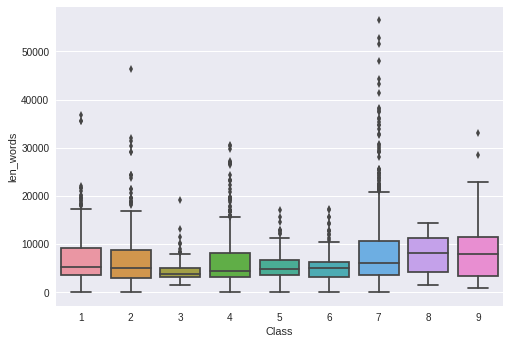

In [0]:
sns.boxplot(y='len_words', x='Class', data=result)

In [0]:
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [0]:
!pip install gensim

In [0]:

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [0]:
i=0
list_of_sent=[]
for sent in train_df['TEXT'].values:
    list_of_sent.append(str(sent).split())

In [0]:
len(list_of_sent)

2124

In [0]:
w2v_model=Word2Vec(list_of_sent,min_count=3,size=100, workers=4)

In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 3 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 3 times  64933
sample words  ['kj', 'c', 'estep', 'al', 'jones', 'jr', 'ch', 'rogers', 'rc', 'rauen', 'ka', 'db', 'germline', 'mutation', 'braf', 'codon', '600', 'compatible', 'human', 'development', 'de', 'novo', 'p', 'v600g', 'identified', 'patient', 'cfc', 'syndrome', 'protein', 'product', 'serine', 'threonine', 'kinase', 'one', 'direct', 'downstream', 'effectors', 'ras', 'somatic', 'mutations', 'occur', 'numerous', 'cancers', 'whereas', 'cause', 'cardio', 'facio', 'cutaneous', 'recurrent', 'v600e']


In [0]:
tfidf_feat = vectorizer.get_feature_names()

In [0]:
sent_vectors = []
for sent in list_of_sent:
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)


In [0]:
test_list_of_sent=[]
for sent in test_df['TEXT'].values:
    test_list_of_sent.append(str(sent).split())

In [0]:
test_sent_vectors = []
for sent in test_list_of_sent:
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)


In [0]:
cv_list_of_sent=[]
for sent in cv_df['TEXT'].values:
    cv_list_of_sent.append(str(sent).split())

In [0]:
cv_sent_vectors = []
for sent in cv_list_of_sent:
    sent_vec = np.zeros(100) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_sent_vectors.append(sent_vec)


for alpha = 1e-06
Log Loss : 1.3003983250658644
for alpha = 1e-05
Log Loss : 1.2873330096484863
for alpha = 0.0001
Log Loss : 1.2820424818993144
for alpha = 0.001
Log Loss : 1.2339108390925244
for alpha = 0.01
Log Loss : 1.243857627404561
for alpha = 0.1
Log Loss : 1.3190664558254361
for alpha = 1
Log Loss : 1.4846768250881852
for alpha = 10
Log Loss : 1.7209750009673384
for alpha = 100
Log Loss : 1.7585762767779687


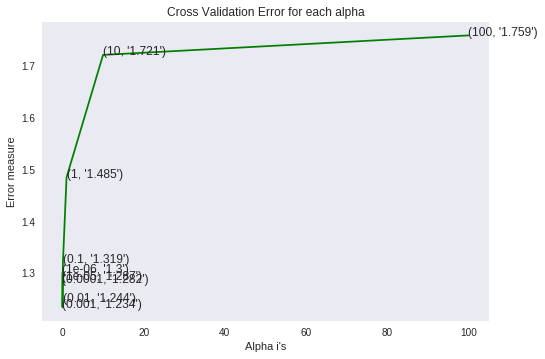

For values of best alpha =  0.001 The train log loss is: 1.1200959367239995
For values of best alpha =  0.001 The cross validation log loss is: 1.2339108390925244
For values of best alpha =  0.001 The test log loss is: 1.2302509145234188


In [0]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(sent_vectors, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(sent_vectors, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_sent_vectors)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(sent_vectors, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(sent_vectors, train_y)

predict_y = sig_clf.predict_proba(sent_vectors)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_sent_vectors)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_sent_vectors)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [0]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_tfidf = hstack((train_gene_var_onehotCoding, sent_vectors)).tocsr()
train_y = np.array(list(train_df['Class']))

test_tfidf= hstack((test_gene_var_onehotCoding, test_sent_vectors)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_tfidf = hstack((cv_gene_var_onehotCoding, cv_sent_vectors)).tocsr()
cv_y = np.array(list(cv_df['Class']))

for alpha = 1e-06
Log Loss : 1.1298581751468748
for alpha = 1e-05
Log Loss : 1.136280621526119
for alpha = 0.0001
Log Loss : 1.1089339519468864
for alpha = 0.001
Log Loss : 1.0810794257055398
for alpha = 0.01
Log Loss : 1.1676555411573324
for alpha = 0.1
Log Loss : 1.31968381947528
for alpha = 1
Log Loss : 1.6090267933578142
for alpha = 10
Log Loss : 1.7463918478684817
for alpha = 100
Log Loss : 1.760909759664612


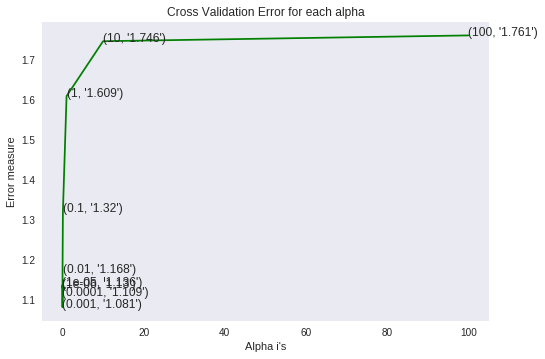

For values of best alpha =  0.001 The train log loss is: 0.8495340397926979
For values of best alpha =  0.001 The cross validation log loss is: 1.0810794257055398
For values of best alpha =  0.001 The test log loss is: 1.0992218519230175


In [0]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 5
Log Loss : 1.0818568954744245
for alpha = 11
Log Loss : 1.1400403550591345
for alpha = 15
Log Loss : 1.1687695383934478
for alpha = 21
Log Loss : 1.1954779353893972
for alpha = 31
Log Loss : 1.2159026178744343
for alpha = 41
Log Loss : 1.2448102027641323
for alpha = 51
Log Loss : 1.255805316456478
for alpha = 99
Log Loss : 1.3055404067275678


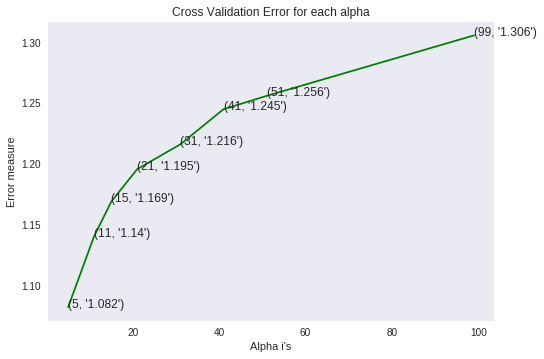

For values of best alpha =  5 The train log loss is: 0.8985319865628024
For values of best alpha =  5 The cross validation log loss is: 1.0818568954744245
For values of best alpha =  5 The test log loss is: 1.124311342651412


In [0]:


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [0]:

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_tfidf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_tfidf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_tfidf)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
        
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.1463777358689218
for n_estimators = 100 and max depth =  10
Log Loss : 1.0468428576180664
for n_estimators = 200 and max depth =  5
Log Loss : 1.147029897573704
for n_estimators = 200 and max depth =  10
Log Loss : 1.0420295335185734
for n_estimators = 500 and max depth =  5
Log Loss : 1.1448321673888782
for n_estimators = 500 and max depth =  10
Log Loss : 1.0410993491982985
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1405830360293663
for n_estimators = 1000 and max depth =  10
Log Loss : 1.0391201328506527
for n_estimators = 2000 and max depth =  5
Log Loss : 1.137956113816267
for n_estimators = 2000 and max depth =  10
Log Loss : 1.0380575197372124
For values of best estimator =  2000 The train log loss is: 0.6359414929465206
For values of best estimator =  2000 The cross validation log loss is: 1.0380575197372124
For values of best estimator =  2000 The test log loss is: 1.0768039619814254


In [0]:
hstack((train_x_tfidf,np.array(train_df['len_words'])[:,None]))

<2124x1927859 sparse matrix of type '<class 'numpy.float64'>'
	with 20504579 stored elements in COOrdinate format>

In [0]:
test_x_tfidf.shape

(665, 55068)

In [0]:
hstack((test_x_tfidf,np.array(test_df['len_words'])[:,None]))
hstack((cv_x_tfidf,np.array(cv_df['len_words'])[:,None]))

<532x1927859 sparse matrix of type '<class 'numpy.float64'>'
	with 4823718 stored elements in COOrdinate format>

for alpha = 1e-06
Log Loss : 1.1849131955320173
for alpha = 1e-05
Log Loss : 1.0674324956866286
for alpha = 0.0001
Log Loss : 0.9619871542462852
for alpha = 0.001
Log Loss : 1.0166960526065871
for alpha = 0.01
Log Loss : 1.1617094207568768
for alpha = 0.1
Log Loss : 1.3594545908884497
for alpha = 1
Log Loss : 1.443234694959981
for alpha = 10
Log Loss : 1.456794608756432
for alpha = 100
Log Loss : 1.4584758074284614


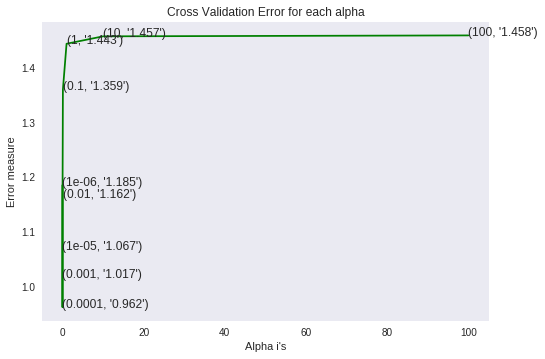

In [0]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [0]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.41654266077331503
For values of best alpha =  0.0001 The cross validation log loss is: 0.9619871542462852
For values of best alpha =  0.0001 The test log loss is: 0.988311195134016



Log loss : 0.9619871542462852
Number of mis-classified points : 0.325187969924812
-------------------- Confusion matrix --------------------


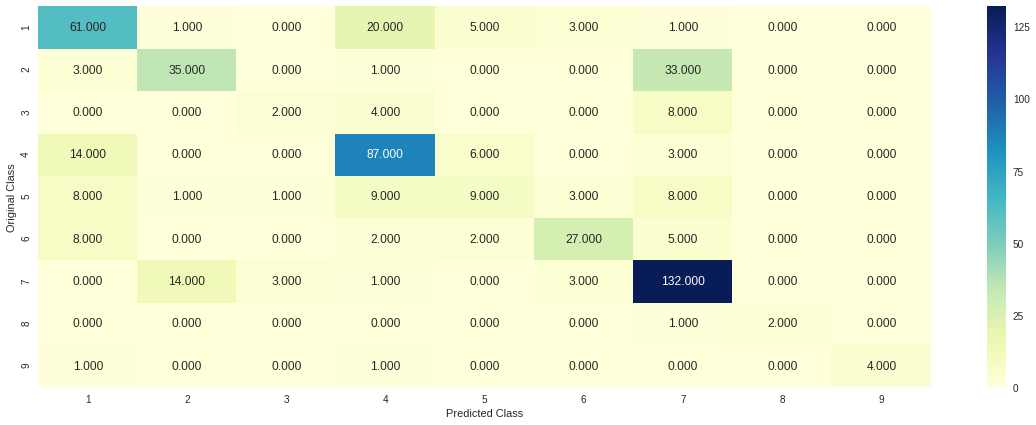

-------------------- Precision matrix (Columm Sum=1) --------------------


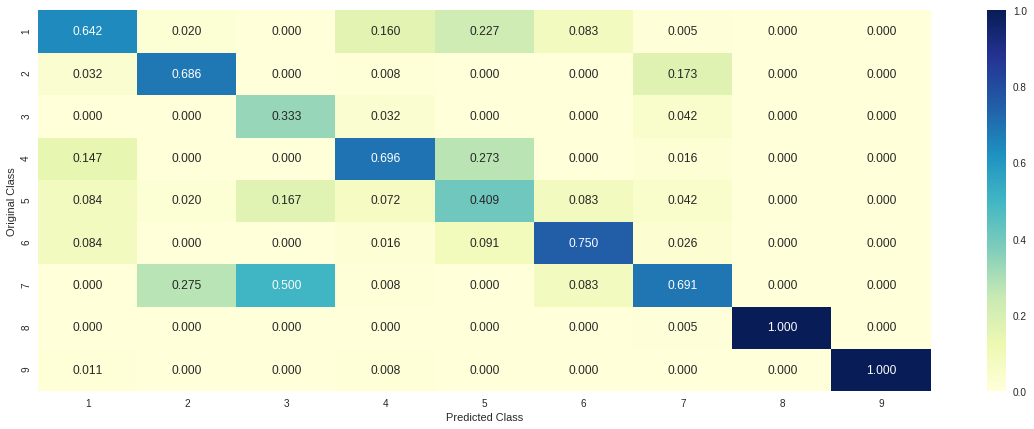

-------------------- Recall matrix (Row sum=1) --------------------


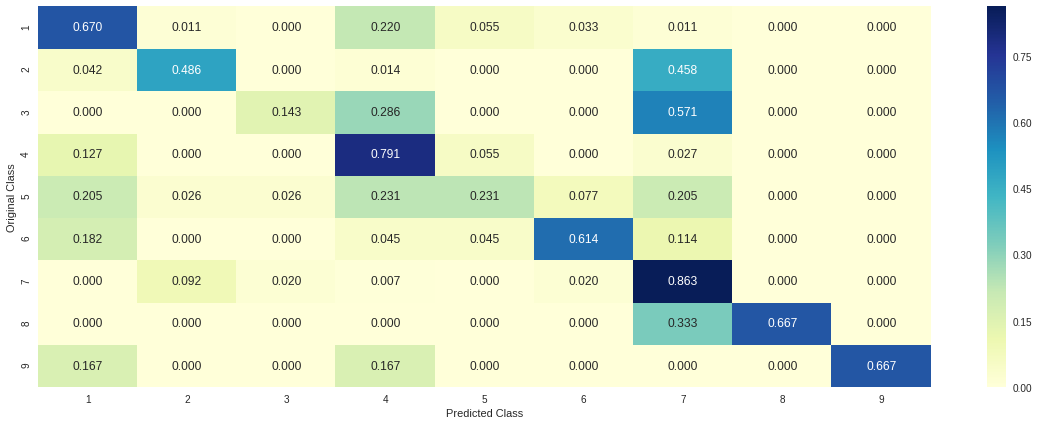

In [0]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, cv_x_tfidf, cv_y, clf)

<h1>Report</h1>


In [6]:
!pip install prettytable

In [0]:
from prettytable import PrettyTable

<h2>Procedure</h2>
Given three features Gene, Variation and Text And we have to predict the correct lable among the given 9 labels

Trying various embeddings like response coding, onehot encoding for catogerical data and minimizing the log loss


Trying Various Text Embeddings like response coding, bag of words, Tfidf (one-grams,two-grams,n-grams) and minimizing the log loss


also trying Word to vec Tfidf Word to vec to minimize logloss
TRying various Feature Enginnering like adding length of text

<h4>Using TFIDF Data for WordEmbeddings</h4>

In [10]:
x = PrettyTable()

x.field_names = ["Model","alpha" ," Train log laws","CV_log_loss","Test log laws", "Missclassification"]

x.add_row(["Naive Bayes",0.001,0.6659140457965383,1.1266745649081906,1.1752847754167381,0.33270676691729323])
x.add_row(["K Nearest Neighbour Classification",5,0.9002217393343086,1.0586079540789077,1.1420660387886843,0.36466165413533835])
x.add_row(["Logistic Regression",0.0001,0.428297539452384,0.9281061869676464,0.9945964154840102,0.31390977443609025])
x.add_row(["Linear Support Vector Machines",0.001,0.5675260123008236,1.035429234638376, 1.1017248527830692,0.3308270676691729])
x.add_row(["RandomForestClassifier",2000,0.6801863303091096,1.0496496626389358, 1.0939609577844478,0.34774436090225563])
x.add_row(["StackingClassifier","NaN", 0.4113088982309288,1.0126743543204015,1.0126743543204015,0.3383458646616541])
x.add_row(["Majority VotingClassifier","NaN",  0.5632408138499149,0.9913366791328627,1.0381328562106995,0.3278195488721804])
print(x)

+------------------------------------+--------+--------------------+--------------------+--------------------+---------------------+
|               Model                | alpha  |   Train log laws   |    CV_log_loss     |   Test log laws    |  Missclassification |
+------------------------------------+--------+--------------------+--------------------+--------------------+---------------------+
|            Naive Bayes             | 0.001  | 0.6659140457965383 | 1.1266745649081906 | 1.1752847754167381 | 0.33270676691729323 |
| K Nearest Neighbour Classification |   5    | 0.9002217393343086 | 1.0586079540789077 | 1.1420660387886843 | 0.36466165413533835 |
|        Logistic Regression         | 0.0001 | 0.428297539452384  | 0.9281061869676464 | 0.9945964154840102 | 0.31390977443609025 |
|   Linear Support Vector Machines   | 0.001  | 0.5675260123008236 | 1.035429234638376  | 1.1017248527830692 |  0.3308270676691729 |
|       RandomForestClassifier       |  2000  | 0.6801863303091096 | 

<h4>TFIDF WITH 1000 FEATURES</h4>

In [11]:
x = PrettyTable()

x.field_names = ["Model","alpha" ," Train log laws","CV_log_loss","Test log laws", "Missclassification"]

x.add_row(["Naive Bayes",0.1,0.6852256538451788,1.1596414003928837,1.201499253127227,0.3954887218045113])
x.add_row(["K Nearest Neighbour Classification",5,0.8856996047924309,1.0476978416824765,1.1057094487440728,0.37593984962406013])
x.add_row(["Logistic Regression",0.0001,0.4778875050451089,0.9726146566847341,1.0307520273410264, 0.3804511278195489])
x.add_row(["Linear Support Vector Machines",0.0001,0.5445149569513164,1.079427653010871,1.1207674573783144,0.3879699248120301])
x.add_row(["RandomForestClassifier",2000,0.5706997877246374,1.040338062990306, 1.0688083085258875,0.3458646616541353])

print(x)

+------------------------------------+--------+--------------------+--------------------+--------------------+---------------------+
|               Model                | alpha  |   Train log laws   |    CV_log_loss     |   Test log laws    |  Missclassification |
+------------------------------------+--------+--------------------+--------------------+--------------------+---------------------+
|            Naive Bayes             |  0.1   | 0.6852256538451788 | 1.1596414003928837 | 1.201499253127227  |  0.3954887218045113 |
| K Nearest Neighbour Classification |   5    | 0.8856996047924309 | 1.0476978416824765 | 1.1057094487440728 | 0.37593984962406013 |
|        Logistic Regression         | 0.0001 | 0.4778875050451089 | 0.9726146566847341 | 1.0307520273410264 |  0.3804511278195489 |
|   Linear Support Vector Machines   | 0.0001 | 0.5445149569513164 | 1.079427653010871  | 1.1207674573783144 |  0.3879699248120301 |
|       RandomForestClassifier       |  2000  | 0.5706997877246374 | 

<h4>TFIDF_ With ngrams</h4>

In [13]:
x = PrettyTable()
x.field_names = ["Model","alpha" ," Train log laws","CV_log_loss","Test log laws", "Missclassification"]
x.add_row(["Logistic Regression",0.0001,0.41654266077331503,0.9210842005806733,0.988311195134016, 0.31390977443609025])
print(x)

+---------------------+--------+---------------------+--------------------+-------------------+---------------------+
|        Model        | alpha  |    Train log laws   |    CV_log_loss     |   Test log laws   |  Missclassification |
+---------------------+--------+---------------------+--------------------+-------------------+---------------------+
| Logistic Regression | 0.0001 | 0.41654266077331503 | 0.9210842005806733 | 0.988311195134016 | 0.31390977443609025 |
+---------------------+--------+---------------------+--------------------+-------------------+---------------------+


<h3>Classification With only  Avverage WORD TO VEC embeddings</h3>
<p>For values of best alpha =  0.001 The train log loss is: 1.1200959367239995<br>
  
For values of best alpha =  0.001 The cross validation log loss is: 1.2339108390925244<br>
For values of best alpha =  0.001 The test log loss is: 1.2302509145234188</p>
<h3>For Entire Model Using Logistic Regression</h3>
<p>For values of best alpha =  0.001 The train log loss is: 0.8495340397926979</p>
For values of best alpha =  0.001 The cross validation log loss is: 1.0810794257055398</p>
For values of best alpha =  0.001 The test log loss is: 1.0992218519230175</p>

<h4>Final Model With LogLoss Less than 1 </h4>

The train log loss is: 0.41654266077331503

The cross validation log loss is: 0.9619871542462852

 The test log loss is: 0.988311195134016